In [1]:
from STIS_pipeline_functions import *

/Users/natalieallen/opt/anaconda3/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


In [2]:
# read in data and calibration files - the test directory I have has 
# two different instruments so I just quickly sort those
data_files = sorted(glob.glob("MAST_2022-03-30T1444/HST/*/*flt.fits"))
files_750 = []
files_430 = []
for i in data_files:
    if "39" in i:
        if "od9m39090" in i:
            flat = i
        else:
            files_750.append(i)
    else:
        files_430.append(i)

In [3]:
# get the data from the files - since I use default settings, it reads out: data, header, jitter, dqs
data = get_data(files_430)

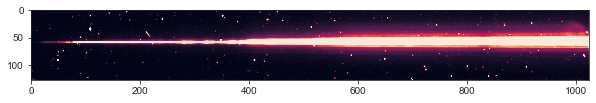

In [4]:
# check on one of the data frames (first part of data)
plt.figure(figsize = (10,10))
im = plt.imshow(data[0][0])
im.set_clim(0,150)

In [5]:
# initialize a list for and then create traces for each of the data frames
trace_list = []
for i in data[0]:
    # trace wants xi, xf, and an initial y guess - these are numbers I just chose from some testing
    # it can be seen above this just corresponds to the strongest flux
    # this function is fast so you can test for yourself if these values don't work!
    trace = trace_spectrum(i, 550,1000,60)
    trace_list.append(trace)

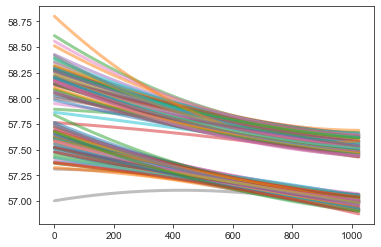

In [6]:
# fit a polynomial to the traces - I just use a second-order chebyshev
# and i fit it over the whole length of the data frame instead of just what was use for the fit
trace_fit = []
for j in trace_list:
    coeffs1 = chebyshev.chebfit(j[0], j[1], deg=2)
    # plotting just to check everything looks okay
    plt.plot(np.arange(len(data[0][0][0])),chebyshev.chebval(np.arange(len(data[0][0][0])),coeffs1),lw=3, alpha = 0.5)
    trace = [np.arange(len(data[0][0][0])),chebyshev.chebval(np.arange(len(data[0][0][0])),coeffs1)]
    trace_fit.append(trace)
plt.show()

# there's maybe some outliers here, but this is just an initial trace to feed into the cleaning function
# so we don't worry about it - should subside once the cosmic rays are cleaned

In [7]:
# now to clean the data - default is all steps on (dq, difference_correct, hc_correct, spline_correct)
# i'm breaking up the orbits manually here, not sure what the best way to do this automatically is yet
cleaned_1 = clean_data(data[0][:4], dqs = data[3][:4], traces = trace_fit[:4])
cleaned_2= clean_data(data[0][4:8], dqs = data[3][4:8], traces = trace_fit[4:8])
cleaned_3 = clean_data(data[0][8:12], dqs = data[3][8:12], traces = trace_fit[8:12])


In [23]:
cleaned_4 = clean_data(data[0][12:17], data[3][12:17], traces = trace_fit[12:17])
cleaned_5 = clean_data(data[0][17:22], data[3][17:22], traces = trace_fit[17:22])
cleaned_6 = clean_data(data[0][22:27], data[3][22:27], traces = trace_fit[22:27])

cleaned_7 = clean_data(data[0][27:32], data[3][27:32], traces = trace_fit[27:32])
cleaned_8 = clean_data(data[0][32:37], data[3][32:37], traces = trace_fit[32:37])
cleaned_9 = clean_data(data[0][37:42], data[3][37:42], traces = trace_fit[37:42])

cleaned_10 = clean_data(data[0][42:47], data[3][42:47], traces = trace_fit[42:47])
cleaned_11 = clean_data(data[0][47:52], data[3][47:52], traces = trace_fit[47:52])
cleaned_12 = clean_data(data[0][52:57], data[3][52:57], traces = trace_fit[52:57])


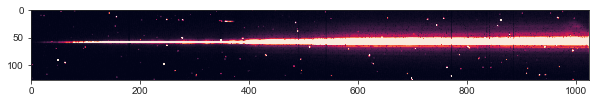

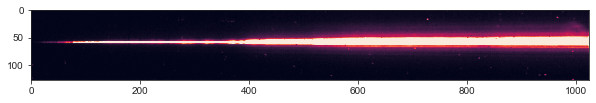

In [22]:
# comparison between the original and the cleaned image
# can easily see the lack of cosmic rays/bad pixels and removal of bad columns
plt.figure(figsize = (10,10))
im = plt.imshow(data[0][1])
im.set_clim(0,200)
plt.show()
plt.figure(figsize = (10,10))
cim = plt.imshow(cleaned_1[1])
cim.set_clim(0,200)
plt.show()


In [24]:
# just putting all of the cleaned files into one list
transit_cleaned = [*cleaned_1, *cleaned_2, *cleaned_3, *cleaned_4, *cleaned_5, *cleaned_6, *cleaned_7, *cleaned_8, *cleaned_9, *cleaned_10, *cleaned_11, *cleaned_12]


In [25]:
# save all of the cleaned images - doing this manually now, but will implement into the function later
# probably want to save the file names for the used data files to use
if os.path.exists("cleaned_data") != True:
    os.makedirs("cleaned_data")
for i in range(len(transit_cleaned)):
    filename = "cleaned_time_" + str(i) + ".fits"
    fits.writeto("cleaned_data/"+filename, transit_cleaned[i])
    


In [ ]:
# now for the spectral extraction - I do simple extraction here because I am still testing some settings with optimal
spectra = []
for i in range(len(transit_cleaned)):
    spec = spectral_extraction(transit_cleaned[i], trace_fit[i], method = "simple")
    spectra.append(spec)